We are interested in finding the state $(z, k)$  of the linear system (2.1) in the case where $\bar{h}=1$ et $\bar{\psi}=0$, $f_0=g_0=0$:
\begin{equation}
	\left\{
	\begin{aligned}
		&z_{t}-z_{xx} + n z=0 & & \text {in}\; \tilde{Q} := (-L, L) \times (0, T), \\
		&z(-1,\cdot)=z(1,\cdot)=0  & & \text {in}\;(0,T), \\
		&k^{\prime}+2\mu z_{x}(1,\cdot)=0 & & \text {in}\;(0,T),  \\
		& k(0)=k_{0},\\
		& z(\cdot,0)=z_{0}, & &\text {in}\;(-L, L).
	\end{aligned}
	\right.
\end{equation}
For $k_0=0.5$ and $z_0=\sin(\pi x)$, We are looking to find a control $v$ such that : $z(x,T)=0, ∀ x\in (-L, L)$, and $k(T)=0$.
We will consider the case $n=-1$.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Physical parameters
mu =0.5  # Coefficient in the dynamic condition
L = 1    # Spatial domain (-1, 1)
T = 2  # Time domain (0, T)
n = -1

In [3]:
# Neural Networks
# Network for the state z(x,t)
z_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the state k(t)
k_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((1,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])



In [4]:
# Loss function
def loss_fn():
    # sampling points
    x_sample = tf.random.uniform((1000, 1), -L, L)
    t_sample = tf.random.uniform((1000, 1), 0, T)
    xt_sample = tf.concat([x_sample, t_sample], axis=1)
    x_one_t_sample = tf.concat([tf.ones_like(t_sample), t_sample], axis=1)

    # Initial conditions
    x_init = tf.random.uniform((1000, 1), -L, L)
    z_init_pred = z_net(tf.concat([x_init, tf.zeros_like(x_init)], axis=1))
    def z_0(x):
        return tf.where((x > 0) & (x < 1), tf.sin(np.pi * x), tf.zeros_like(x))
    loss_init_z = tf.reduce_mean(tf.square(z_init_pred - z_0(x_init))) 

    t_init = tf.zeros((100, 1))
    k_init_pred = k_net(t_init)
    loss_init_k = tf.reduce_mean(tf.square(k_init_pred - 0.5)) # k(0)=0.5


    # First equation: z_{t}-z_{xx} +n z=0
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xt_sample)
        z_pred = z_net(xt_sample)
        k_pred = k_net(t_sample)
        z_x = tape.gradient(z_pred, xt_sample)[:, 0:1]
        z_t = tape.gradient(z_pred, xt_sample)[:, 1:2]
        z_xx = tape.gradient(z_x, xt_sample)[:, 0:1]
    loss_pde = tf.reduce_mean(tf.square(z_t - z_xx + n * z_pred ))

    #loss_pde = tf.reduce_mean(tf.square(z_t - z_xx + z_pred * indicator_function(x_sample, t_sample)))

    # Boundary conditions
    t_boundary = tf.random.uniform((100, 1), 0, T)
    z_boundary_negL = z_net(tf.concat([-L * tf.ones_like(t_boundary), t_boundary], axis=1))
    z_boundary_L = z_net(tf.concat([L * tf.ones_like(t_boundary), t_boundary], axis=1))
    loss_boundary = tf.reduce_mean(tf.square(z_boundary_negL)) + tf.reduce_mean(tf.square(z_boundary_L)) # z(-1,t)=z(1,t)=0

    # Computation of z_x(1,t)
    with tf.GradientTape() as tape2:
      tape2.watch(x_one_t_sample)
      z_pred_boundary = z_net(x_one_t_sample)
      z_x_boundary = tape2.gradient(z_pred_boundary, x_one_t_sample)[:, 0:1]

    # Third equation k^{\prime}+2\mu z_{x}(1,\cdot)=0
    loss_dyn_k = tf.reduce_mean(tf.square(tf.gradients(k_pred, t_sample)[0] + 2 * mu * z_x_boundary))

    return 50 * loss_init_z + 10 * loss_init_k + loss_pde + loss_dyn_k + 30 * loss_boundary
    

In [5]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = loss_fn()
    gradients = tape.gradient(loss, z_net.trainable_variables + k_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, z_net.trainable_variables + k_net.trainable_variables))
    return loss

In [6]:
# Training
epochs = 30000
loss_history_train = []
for epoch in range(epochs):
    loss = train_step()
    loss_history_train.append(loss.numpy())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

Epoch 0: Loss = 15.896685600280762
Epoch 100: Loss = 4.957756996154785
Epoch 200: Loss = 3.270854949951172
Epoch 300: Loss = 2.313615322113037
Epoch 400: Loss = 1.7842192649841309
Epoch 500: Loss = 1.5175762176513672
Epoch 600: Loss = 1.2022398710250854
Epoch 700: Loss = 0.9929186105728149
Epoch 800: Loss = 0.8144006133079529
Epoch 900: Loss = 0.6749902963638306
Epoch 1000: Loss = 0.5520603656768799
Epoch 1100: Loss = 0.429449200630188
Epoch 1200: Loss = 0.4304676949977875
Epoch 1300: Loss = 0.3615296185016632
Epoch 1400: Loss = 0.28672975301742554
Epoch 1500: Loss = 0.2530342638492584
Epoch 1600: Loss = 0.18681254982948303
Epoch 1700: Loss = 0.23331846296787262
Epoch 1800: Loss = 0.16245828568935394
Epoch 1900: Loss = 0.19494318962097168
Epoch 2000: Loss = 0.2184865027666092
Epoch 2100: Loss = 0.13490092754364014
Epoch 2200: Loss = 0.16525283455848694
Epoch 2300: Loss = 0.12369198352098465
Epoch 2400: Loss = 0.14569950103759766
Epoch 2500: Loss = 0.13875560462474823
Epoch 2600: Loss =

In [7]:
Nx, Nt = 1000, 1000  # Number of points for x ant t
x = np.linspace(0, L, Nx).reshape(-1, 1)
t = np.linspace(0, T, Nt).reshape(-1, 1)
X, T_grid = np.meshgrid(x, t)

In [8]:
# Network evaluation
xt_eval = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
z_eval = z_net.predict(xt_eval).reshape(Nt, Nx)
k_eval = k_net(t).numpy()

31250/31250 [==============================] - 19s 600us/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


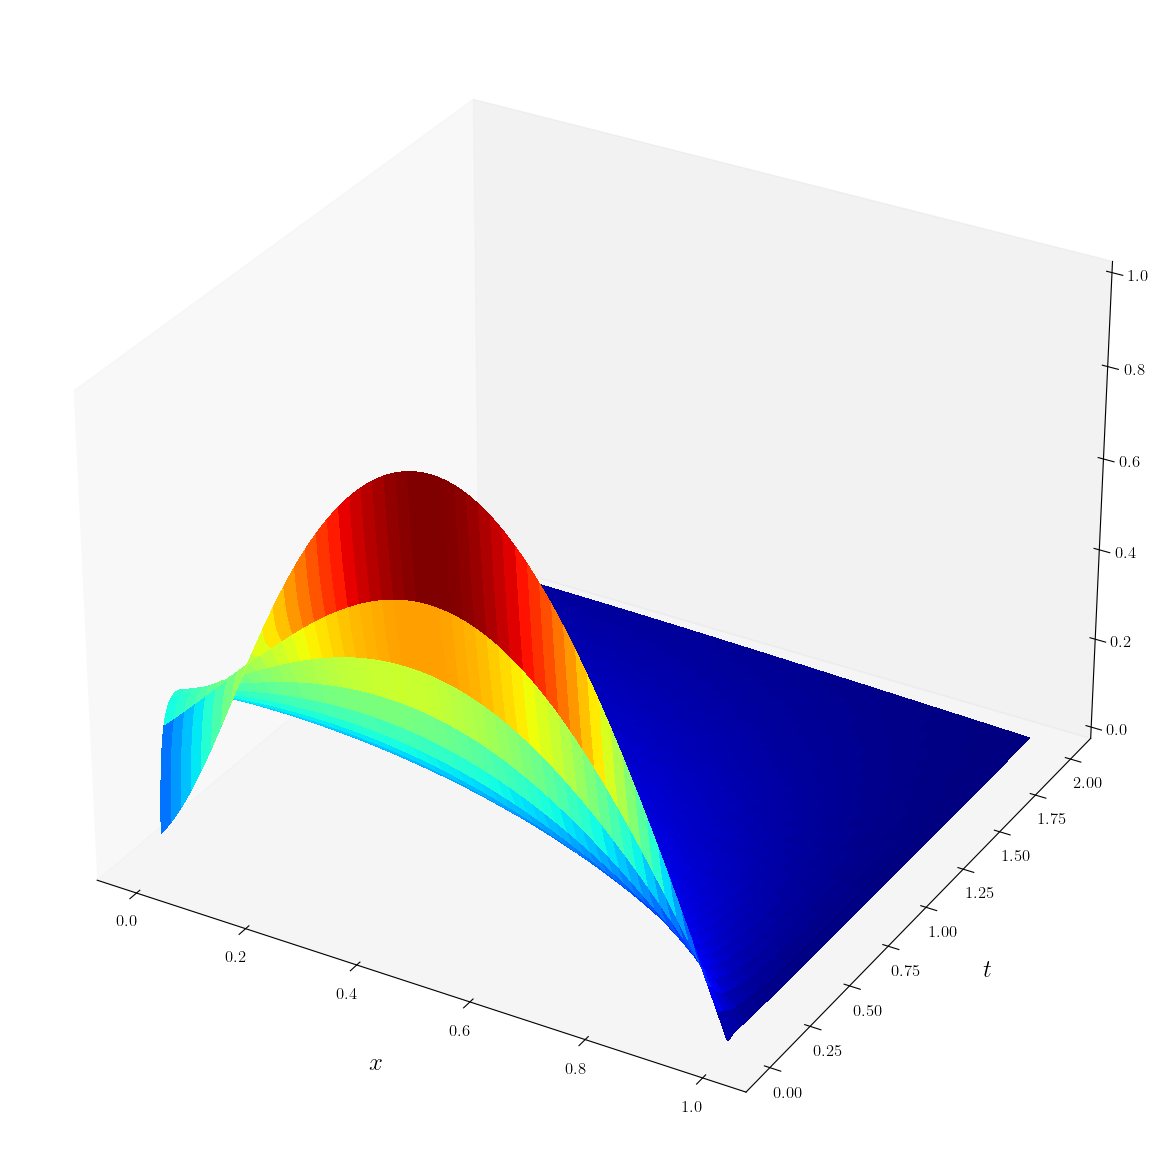

In [9]:
# Visualization
X, T_grid = np.meshgrid(x, t)
# Visualization 3D of z(x, t)
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text
    "font.family": "serif",  # Use serif font (default LaTeX style)
    "font.size": 12  # Adjust font size
})
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(X, T_grid, z_eval, cmap='jet', linewidth=0, antialiased=False)
ax.grid(False)
#ax.set_title('........ z(x, t)')
#plt.legend(fontsize=14)
ax.set_xlabel('$x$', fontsize=18, color="black", labelpad=20)
ax.set_ylabel('$t$', fontsize=18, color="black", labelpad=20)
#ax.set_zlabel('State $z(x,t)$', color="black", labelpad=20)
plt.savefig('../figures/uncontrolled_state_z_linear_n_minus_1.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


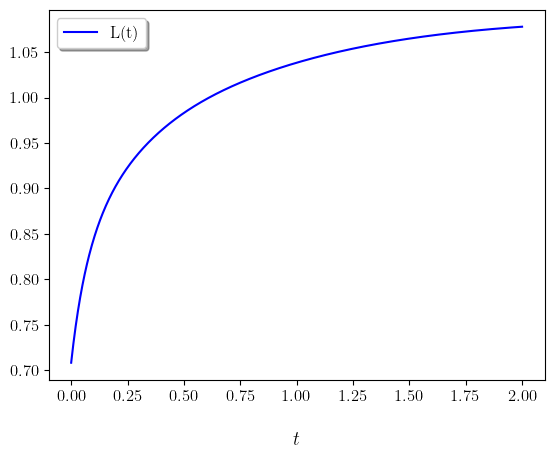

In [10]:
# Visualization 2D de k(t)
L_eval = np.sqrt(k_eval)
plt.figure()
plt.plot(t, L_eval, label=r'L(t)', color='blue')
plt.xlabel(r'$t$', fontsize=14, color="black", labelpad=20)
#plt.ylabel(r'$k(t)$', fontsize=18, color="black", labelpad=20)
#plt.title('......... k(t)')
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/uncontrolled_state_L_linear_n_minus_1.eps', format='eps')
plt.show()